## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('AZN-AstraZeneca.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.610001,41.759998,41.480000,41.759998,36.845531,4590000
2019-03-04,41.730000,41.810001,41.389999,41.689999,36.783772,3948200
2019-03-05,41.560001,42.610001,41.560001,42.310001,37.330799,5668200
2019-03-06,42.360001,42.389999,41.930000,42.029999,37.083755,2490000
2019-03-07,41.610001,41.770000,41.330002,41.660000,36.757294,5283900
...,...,...,...,...,...,...
2024-05-24,78.129997,78.889999,78.080002,78.540001,78.540001,3566600
2024-05-28,77.779999,77.820000,76.489998,76.620003,76.620003,4199000
2024-05-29,76.129997,76.510002,75.800003,76.080002,76.080002,4653800


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.6)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
23/23 - 12s - 507ms/step - loss: 0.0297
Epoch 2/50
23/23 - 2s - 86ms/step - loss: 0.0078
Epoch 3/50
23/23 - 2s - 86ms/step - loss: 0.0052
Epoch 4/50
23/23 - 2s - 90ms/step - loss: 0.0050
Epoch 5/50
23/23 - 3s - 148ms/step - loss: 0.0048
Epoch 6/50
23/23 - 3s - 124ms/step - loss: 0.0045
Epoch 7/50
23/23 - 3s - 134ms/step - loss: 0.0047
Epoch 8/50
23/23 - 3s - 129ms/step - loss: 0.0049
Epoch 9/50
23/23 - 3s - 118ms/step - loss: 0.0049
Epoch 10/50
23/23 - 3s - 112ms/step - loss: 0.0041
Epoch 11/50
23/23 - 3s - 116ms/step - loss: 0.0043
Epoch 12/50
23/23 - 2s - 106ms/step - loss: 0.0044
Epoch 13/50
23/23 - 2s - 103ms/step - loss: 0.0037
Epoch 14/50
23/23 - 2s - 106ms/step - loss: 0.0034
Epoch 15/50
23/23 - 2s - 96ms/step - loss: 0.0033
Epoch 16/50
23/23 - 2s - 85ms/step - loss: 0.0037
Epoch 17/50
23/23 - 2s - 82ms/step - loss: 0.0035
Epoch 18/50
23/23 - 2s - 85ms/step - loss: 0.0033
Epoch 19/50
23/23 - 2s - 86ms/step - loss: 0.0030
Epoch 20/50
23/23 - 2s - 86ms/step - loss: 0.00

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step


## Calculate the error of the model

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
# Evaluate the accuracy of test

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, y_pred)


print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)
print(f"MAE on Test dataset: ", test_mae)

MAPE on Test dataset:  0.02345190433528499
RMSE on Test dataset:  1.9015151135266903
MSLE on Test dataset:  0.000808689649805572
MAE on Test dataset:  1.5710647250317842


## Predict Close price for 30 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Predict Close price for 30 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_30_days = []

for i in range(30):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_30_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━

In [14]:
# Show the result of predict 30 next days 
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

[75.59144  75.36155  75.06273  74.68044  74.256996 73.83281  73.42819
 73.04736  72.68741  72.34408  72.01396  71.69458  71.38389  71.08014
 70.78166  70.48701  70.19503  69.904854 69.61585  69.327644 69.04001
 68.75288  68.46626  68.18024  67.89491  67.610374 67.326775 67.04418
 66.76268  66.48231 ]


## Model visualization

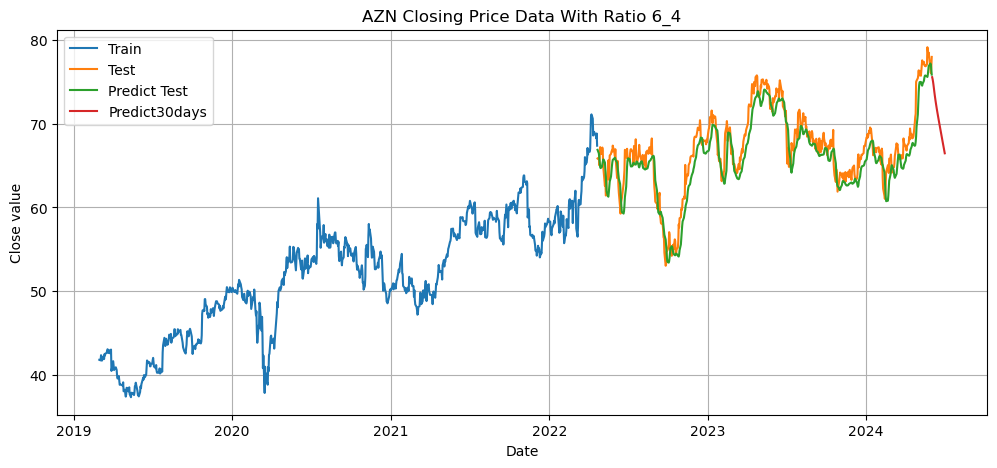

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 30 next days
plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict30days'])
plt.grid()
plt.title("AZN Closing Price Data With Ratio 6_4")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_64_30days_AZN.png')
plt.show()